# Regresión Lineal

Ejemplo  regisión lineal del libro *Hands-on Machine Learning*

## Extrasión de datos

este ejemplo se va hacer una optener un data set de ....

In [4]:
import os
import tarfile
import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall

fetch_housing_data()


El siguiente paso es cargar los datos a un DataFrame de pandas *housing*.

Observamos que se tiene 10 atributos *longitude, latitude, housing_median_age, total_rooms, total_bed
rooms, population, households, median_income, median_house_value, and
ocean_proximity*


In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


/tmp/ipykernel_346250/4282101.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Observamos que
- El atributo total_bedrooms tiene 20 433 valores no nulos, lo que significa que a 207 registros faltantes.
- El atributo *ocean_proximity* es un atributo no númerico. Para mirar los valores que tiene y cuantos uso *value_counts()*

In [34]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [35]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000



Otra forma rápida de familiarizarte con el tipo de datos con el que estás tratando es graficar un histograma para cada atributo numérico. Un histograma muestra el número de instancias (en el eje vertical) que tienen un rango de valores dado (en el eje horizontal). Le método hist() graficará un histograma para cada atributo numérico.

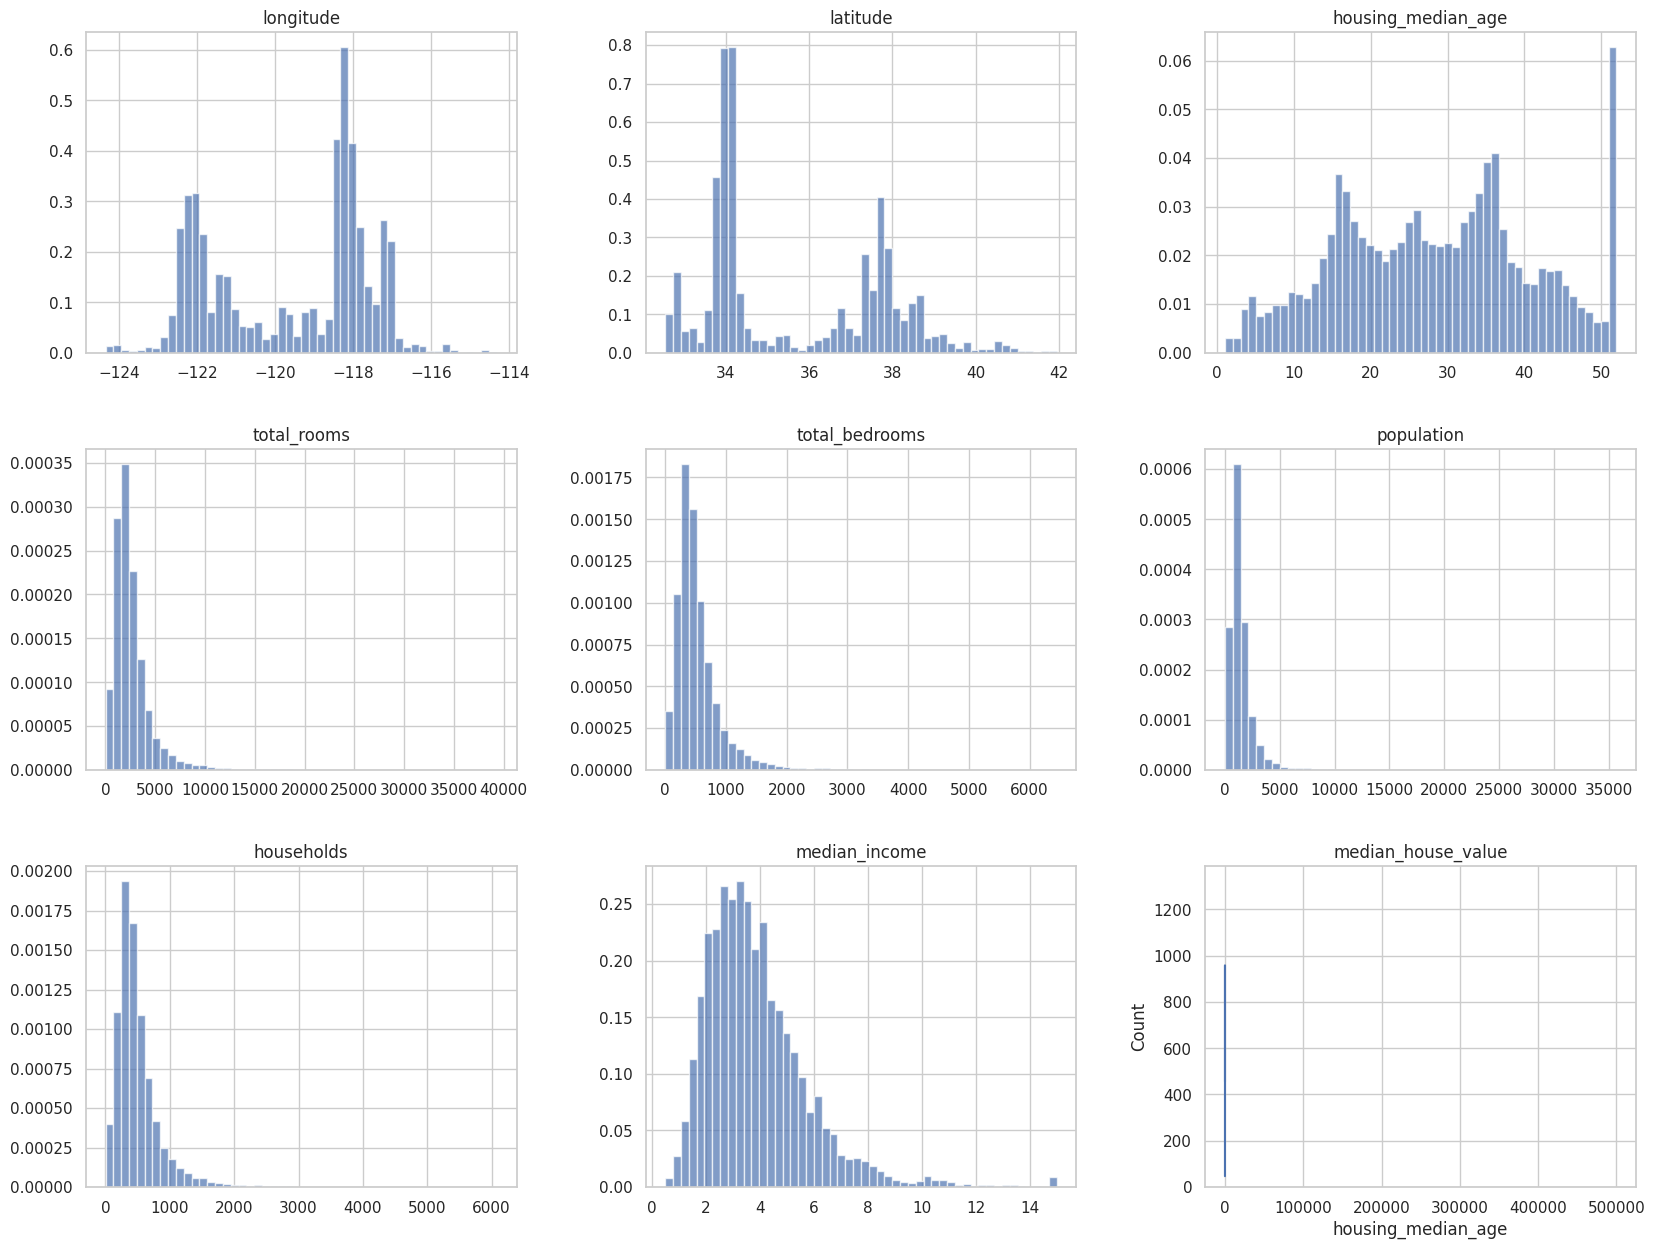

In [36]:
%matplotlib inline
# only in a Jupyter notebook
import matplotlib.pyplot as plt
import seaborn as sns  
# Configurar el estilo de seaborn para mejorar la apariencia de las visualizaciones
sns.set(style="whitegrid")

# Generar histogramas con líneas suavizadas
housing.hist(bins=50, figsize=(20,15), density=True, color='b', alpha=0.7)
sns.histplot(housing['housing_median_age'], kde=True, color='b', alpha=0.1)
plt.show()


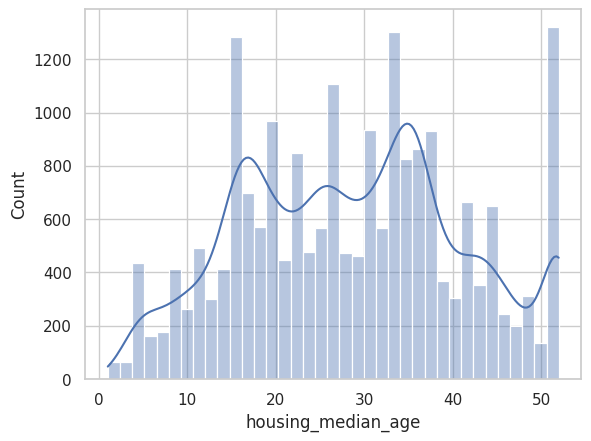

In [37]:
sns.histplot(housing['housing_median_age'], kde=True, color='b', alpha=0.4)
plt.show()

**¿Qué podemos notar?**
- 'median_income' no parece estar en dólares, sino en decenas de miles de dólares. Tendremos que tomar eso en cuenta cuando entrenemos el modelo.
- 'median_housing_age' y 'median_house_value' están restringidos en un rango. Los valores más altos a ese rango se contabilizan como si pertenecieran a un sólo valor. Podemos conseguir más datos o descartar las instancias cuyos datos fueron restringidos
- Muchos atributos fueron escalados. Esto no es malo, simplemente se debe tomar en cuenta al predecir y evaluar el modelo.
- Muchos histogramas son de cola larga (se extienden más hacia un lado de la media que al otro). Esto puede ser un problema para el aprendizaje del modelo. Una solución para obtener una distribución gaussiana sería aplicar un logaritmo a los datos.

## Separación de Datos (Train y Test)
Cuando separamos nuestros datos de prueba (normalmente, el 20% del total de datos) enfrentamos un problema: ¿Cómo saber si no existe un sesgo de elección? Para eso, podemos recurrir a técnicas de muestreo como el muestreo estratificado (tomar porcentajes iguales de cada estrato importante de nuestros datos).

Para nuestro problema, el atributo a considerar sería el estado socioeconómico, el cual podemos encontrar en nuestro dataset como 'median_income'. Ya que queremos elegir por estratos habría que clasificar las instancias por categorías de ingreso.

<Axes: >

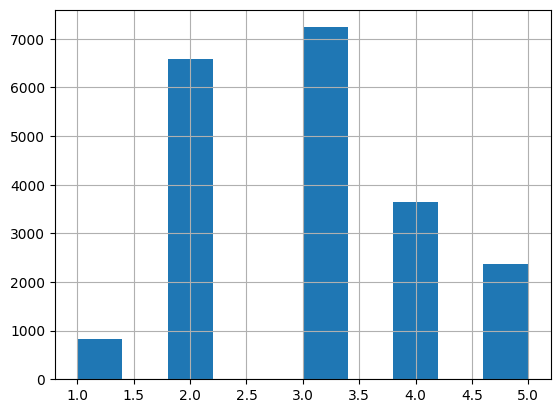

In [12]:
import numpy as np
np.random.seed(42)
# Añadimos el feature 'income_cat' haciendo una discretización de 'median_income'
housing["income_cat"] = pd.cut(housing["median_income"],
                                 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                 labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [39]:
# sklearn tiene una clase útil para realizar un muestreo estratificado
from sklearn.model_selection import StratifiedShuffleSplit

# Definimos número de rondas de separación y el tamaño del test set
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# split() retorna índices que usamos para seleccionar las filas ya separadas
for train_indices, test_indices in spliter.split(housing, housing['income_cat']):
    #print(train_indices)
    #print(test_indices)
    strat_train_set = housing.loc[train_indices]
    strat_test_set = housing.loc[test_indices]

In [40]:
# Veamos qué tan bien representamos a los datos en nuestra separación
print('PROPORCIONES DE LOS DATOS SEPARADOS')
print(strat_train_set['income_cat'].value_counts() / len(strat_train_set))
print()
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
print()
print("PROPORCIONES DEL DATASET COMPLETO")
print(housing["income_cat"].value_counts() / len(housing))

PROPORCIONES DE LOS DATOS SEPARADOS
income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

PROPORCIONES DEL DATASET COMPLETO
income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64


In [41]:
# Ya que hemos separado los datos, eliminamos 'income_cat'
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Vizualización de datos

In [42]:
# Creamos una copia de nuestro train set (sin income_cat).
housing_copy = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

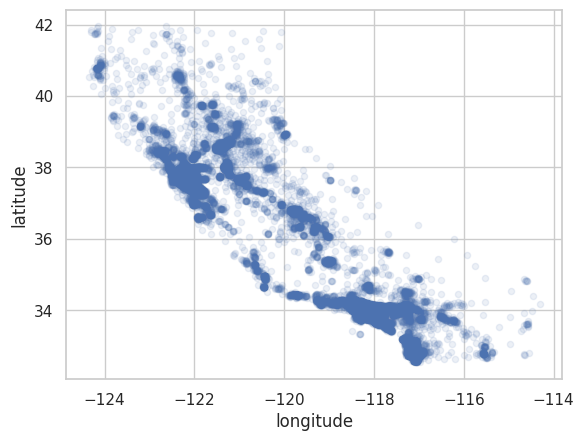

In [43]:

# Visualizemos los datos de forma geográfica
housing.plot.scatter(x='longitude', y='latitude', alpha=0.1)

<img src="datasets/california.png" alt="Ejemplo de imagen local" width="20%">

La visualizacion mejoraría si introducimos más factores:

- Tamaño: representa la cantidad de población en un distrito.
- Color: representa el precio medio de las casas en un distrito.

<Axes: xlabel='longitude', ylabel='latitude'>

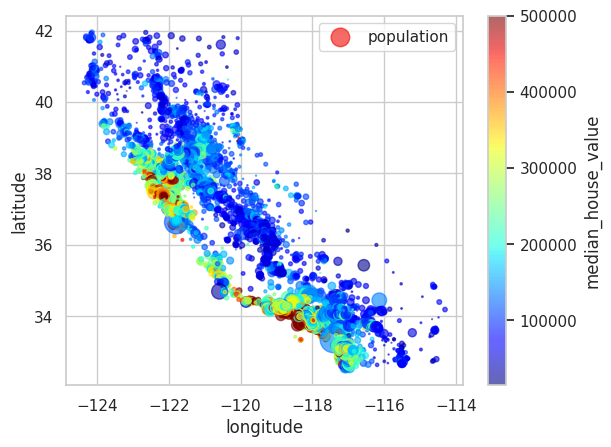

In [44]:
# opciones s y c alteran el tamaño y el color, respectivamente
housing.plot.scatter(x="longitude", y="latitude", alpha=0.6,
                        s=housing["population"] /100, label="population",
                        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)


**Busquemos correlaciones**

Dado que queremos reducir la complejidad del modelo, buscaremos correlaciones entre el feature 'median_house_value' (que es el valor que queremos predecir) y los demás atributos.

#### Limpieza de datos
Hay que eliminar los valores 'ocean_proximuty', para quedarnos con valores numericos

In [6]:
# Copy el dataset sin feature "ocean proximity", es decir, sólo con valores numéricos
housing = housing.drop("ocean_proximity", axis=1)

In [7]:
# Calculamos los coef. de correlación de Pearson con respecto a median_house_value
corr_matrix = housing.corr() # Matriz de correlacion
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

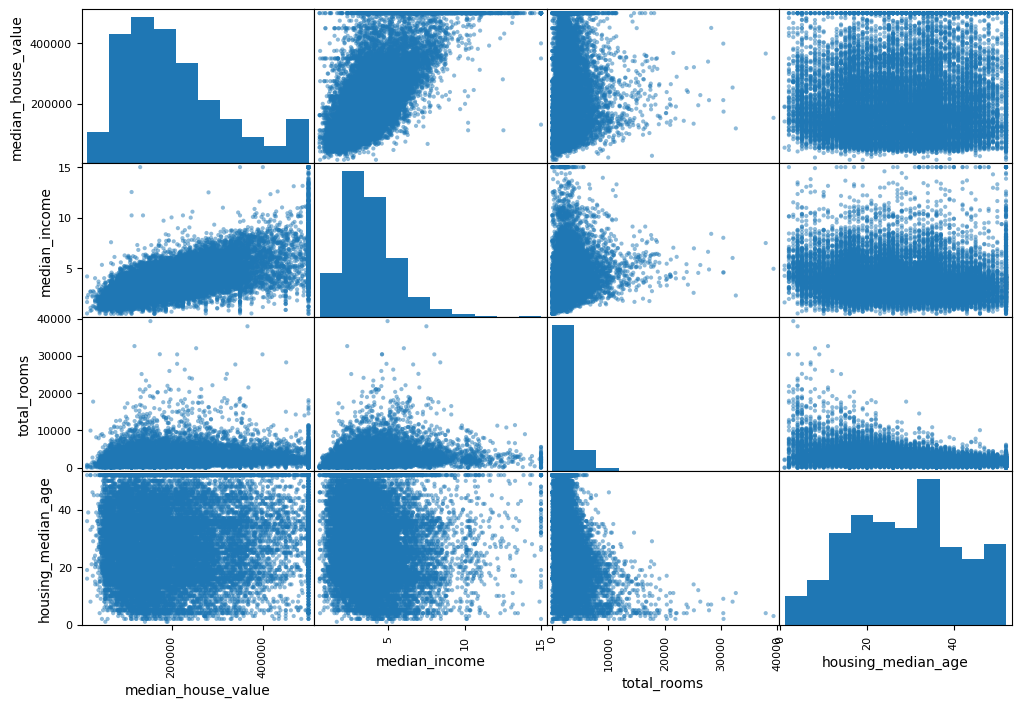

In [8]:
# También podemos calcular y visualizar las correlaciones
from pandas.plotting import scatter_matrix

# Correlación entre 4 atributos prometedores
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
_ = scatter_matrix(housing[attributes], figsize=(12, 8))
# Si nos les funciona, agreguen plt.show()

In [55]:
# Crear una gráfica de dispersión con Seaborn
sns.scatterplot(data=housing, x="median_income", y="median_house_value", hue="median_income", alpha=0.6, palette="dark")

# Añadir etiquetas y título
plt.xlabel("Mediana de Ingresos")
plt.ylabel("Mediana del Valor de la Vivienda")
plt.title("Correlación entre Ingresos y Valor de la Vivienda")

# Mostrar la leyenda
plt.legend(title="Mediana de Ingresos", bbox_to_anchor=(1.05, 1), loc='upper left')

# Guardar la gráfica en un archivo (ajustando el dpi según sea necesario)
plt.savefig("scatter_plot.png", dpi=300)


KeyboardInterrupt: 

La correlación es prometedora, aunque existen problemas: las líneas horizontales de $50,000 y otras más podrían hacer que nuestro modelo se ajuste a estas irregularidades. Una posible solución sería remover estas instancias
### Experimentando con combinaciones de atributos
Antes de pasar al procesamiento de los datos, sería bueno hacer una cuantas pruebas con datos que no estaban en el dataset original, pero cuyas relaciones puedan estar ligadas al problema que queremos resolver. Probaremos con atributos "piezas por casa", "habitaciones por casa" y "personas por casa".

In [9]:

# Añadimos features como a través de operaciones entre features ya existentes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_household"] = housing["total_bedrooms"]/housing["households"]
housing["pop_per_household"] = housing["population"]/housing["households"]

In [10]:
# Calculamos las correlaciones de nuevo
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.688075
rooms_per_household       0.151948
total_rooms               0.134153
housing_median_age        0.105623
households                0.065843
total_bedrooms            0.049686
pop_per_household        -0.023737
population               -0.024650
longitude                -0.045967
bedrooms_per_household   -0.046739
latitude                 -0.144160
Name: median_house_value, dtype: float64

### Limpieza de datos
Como vimos, algunas instancias tenián valores nulos para el atributo 'total_bedrooms'. Podemos descartar las instancias con valores nulos, descartar todo el atributo o rellenar con valores como la media o la mediana.
Podemos usar Pandas para la tarea, pero optaremos por usar Scikit Learn

In [14]:
from sklearn.impute import SimpleImputer

# Definir el imputador
imputer = SimpleImputer(strategy="median")

# Ajustar el imputador a tus datos
imputer.fit(housing)

# Seleccionar solo las columnas numéricas
numeric_columns = housing.select_dtypes(include=[np.number])

# Calcular la mediana solo en las columnas numéricas
median_values_imputer = imputer.statistics_
median_values_real = numeric_columns.median()

# Mostrar las medianas calculadas por el Imputer
print('MEDIANAS CALCULADAS POR EL IMPUTER')
print(median_values_imputer)
print()
print('MEDIANAS REALES')
print(median_values_real)

MEDIANAS CALCULADAS POR EL IMPUTER
[-1.18490000e+02  3.42600000e+01  2.90000000e+01  2.12700000e+03
  4.35000000e+02  1.16600000e+03  4.09000000e+02  3.53480000e+00
  1.79700000e+05  5.22912879e+00  1.04888889e+00  2.81811565e+00
  3.00000000e+00]

MEDIANAS REALES
longitude                   -118.490000
latitude                      34.260000
housing_median_age            29.000000
total_rooms                 2127.000000
total_bedrooms               435.000000
population                  1166.000000
households                   409.000000
median_income                  3.534800
median_house_value        179700.000000
rooms_per_household            5.229129
bedrooms_per_household         1.048889
pop_per_household              2.818116
dtype: float64


In [17]:
# Rellenamos los valores nulos.
X = imputer.transform(housing) #--> ndarray
# Convertirmos el array a un DataFrame
housing_tr = pd.DataFrame(X, columns=housing.columns)

In [18]:
# Ahora no hay datos nulos
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               20640 non-null  float64
 1   latitude                20640 non-null  float64
 2   housing_median_age      20640 non-null  float64
 3   total_rooms             20640 non-null  float64
 4   total_bedrooms          20640 non-null  float64
 5   population              20640 non-null  float64
 6   households              20640 non-null  float64
 7   median_income           20640 non-null  float64
 8   median_house_value      20640 non-null  float64
 9   rooms_per_household     20640 non-null  float64
 10  bedrooms_per_household  20640 non-null  float64
 11  pop_per_household       20640 non-null  float64
 12  income_cat              20640 non-null  float64
dtypes: float64(13)
memory usage: 2.0 MB


### Transformadores

Los transformadores son componentes clave de la infraestructura de preprocesamiento de datos. Permiten realizar operaciones de transformación en tus datos, como imputar valores faltantes, escalar variables numéricas, y codificar variables categóricas.

Reimputar valores se refiere a la acción de sustituir o asignar nuevos valores a las entradas que tienen valores faltantes en un conjunto de datos. Cuando se trabaja con conjuntos de datos del mundo real, es común encontrarse con valores faltantes en algunas observaciones. Estos valores pueden surgir debido a diversos motivos, como errores de medición, problemas de recopilación de datos o simplemente la falta de información.

La reimputación es un paso esencial en el proceso de preprocesamiento de datos y es crucial para garantizar que los modelos de aprendizaje automático puedan trabajar con conjuntos de datos completos y bien estructurados.

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_idx, bedrooms_idx, population_idx, households_idx = 3, 4, 5, 6

# Clase que agrega features al dataset
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args, **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_idx] / X[:, households_idx]
        population_per_household = X[:, population_idx] / X[:, households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Llamamos a la función
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)